## Decitabine treatment RNA-Seq experiments
- #### [Decitabine treatment time-series RNA-Seq experiments in HL60 cell line](#Decitabine-treatment-time-series-RNA-Seq-experiments-in-HL60-cell-line)
- #### [Decitabine treatment RNA-Seq experiments in 5 other AML cell lines](#Decitabine-treatment-RNA-Seq-experiments-in-5-other-AML-cell-lines)

## Load packages, functions and main data

In [1]:
# %load_ext rpy2.ipython

In [1]:
# %%R 
suppressMessages(suppressWarnings(library (GenomicFeatures)))
suppressMessages(suppressWarnings(library (tximport)))
suppressMessages(suppressWarnings(library (tidyverse)))
suppressMessages(suppressWarnings(library (ggplot2)))
suppressMessages(suppressWarnings(library (ggrepel)))
suppressMessages(suppressWarnings(library (DESeq2)))
suppressMessages(suppressWarnings(library (patchwork)))
suppressMessages(suppressWarnings(library (BiocParallel)))
suppressMessages(suppressWarnings(library (gridExtra)))
library(grid)

register(MulticoreParam(18))

In [2]:
source('../scripts/util.R')

In [3]:
# Filter non-informative genes:
filter_low_counts <- function (dds_in , min_count=10){
    # all samples with a count of higher than `min_count`
    keep <- rowSums(counts(dds_in ) > min_count) == ncol(dds_in )
    dds_out <- dds_in [keep,]
    print (paste (nrow(dds_in), 'genes filtered to ->' , nrow(dds_out),'genes!', sep=' ') )
    return (dds_out)
}


plot_PCA <- function(vsd, colData, labels='', gr=c('cond'), title='', leg="none"){
    z <- plotPCA(vsd,intgroup=gr, returnData=TRUE)
    percentVar <- round(100 * attr(z, "percentVar"))
    pca <- ggplot(z, aes(PC1, PC2)) +
            geom_point(aes(colour=group), alpha = 4/10,size=12) + 
            geom_point(shape = 1,size = 12,colour = "black") + 
            # geom_point(
            #     aes(color=group), 
            #     
            # size=10,
            # stroke = 0.5
            # ) +
            geom_text_repel(
                aes(label = labels),
                box.padding = 1.5, max.overlaps = Inf
            ) + #,size = 3.5)) +
            xlab(paste0("PC1: ",percentVar[1],"% variance")) +
            ylab(paste0("PC2: ",percentVar[2],"% variance")) +
            ggtitle (title) + 
            scale_colour_Publication() + 
            theme_Publication(legend.position='top') +
            guides (size = 'none') + theme(legend.title = element_blank()) 
    return (pca)
}

In [4]:
write_Result <- function(res, name_it, col=FALSE, row=FALSE){
    write.table(res,name_it, sep="\t", quote=FALSE, col.names=col, row.names=row)
}


correct_batch <- function (dds,gr,out,labels='',title=''){
    vsd <- varianceStabilizingTransformation(dds, blind=FALSE)
    p0 <- plot_PCA(vsd, gr, labels=labels,title=paste0(title,' Before removeBatchEffect'))
    mat <- assay(vsd)
    
    mat <- limma::removeBatchEffect(mat, vsd$reps) # batch is same as time 
    assay(vsd) <- mat
    p1 <- plot_PCA(vsd, gr, labels=labels,title=paste0(title,' After removeBatchEffect'))
    counts_batch_corrected <- assay(vsd)
    
    if (out == 'plot') {return (p0 + p1)}
    if (out == 'plot1'){return (p1)}
    if (out == 'vsd')  {return (vsd)}
    if (out == 'cbc')  {return (counts_batch_corrected)}
}


ann_Result <- function(res){
    return (
        res %>% data.frame %>% 
        add_column(gene_name=gene2name[rownames(res),]) %>%
        add_column(gene_id=rownames(res)) %>% 
        select (gene_id,gene_name,everything())
    )
}

plot_gene_counts <- function (dds, gene_id,gene_name){
    fiss <- plotCounts(dds, gene_id, intgroup = c("cond"), returnData = TRUE)

    p <- ggplot(fiss,
      aes(x = cond, y = count, color = cond)) + 
      geom_point(size=5,alpha=8/10) + stat_summary(fun=mean, geom="line") +
      scale_y_log10() + 
      theme_bw() + 
      ggtitle(gene_name)
    
    return (p + theme_Publication())
}

Load annotations

In [6]:
# %%R 
txdb.hg19  = makeTxDbFromGFF('../scallop-genome/hg19/hg19.knownGene.gtf', organism='Homo sapiens')

tin_1 <- rtracklayer::import('../scallop-genome/tinat/DAC+SB_TINATs.gtf')%>% data.frame %>% filter(type == "transcript") %>% dplyr::select('gene_id','transcript_id')
tin_2 <- rtracklayer::import('../scallop-genome/tinat/DAC_TINATs.gtf')   %>% data.frame %>% filter(type == "transcript") %>% dplyr::select('gene_id','transcript_id')
tin_3 <- rtracklayer::import('../scallop-genome/tinat/SB939_TINATs.gtf') %>% data.frame %>% filter(type == "transcript") %>% dplyr::select('gene_id','transcript_id')
tins <- rbind(tin_1, tin_2,tin_3) 
colnames(tins) <- c("GENEID", "TXNAME")

# tx2gene objects 
k.hg19 <- keys(txdb.hg19, keytype = "TXNAME")
tx2gene.hg19 <- AnnotationDbi::select(txdb.hg19, k.hg19, "GENEID", "TXNAME")

tx2gene = rbind(tx2gene.hg19, tins)

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”
OK

'select()' returned 1:1 mapping between keys and columns



In [134]:
genes_df = genes(txdb.hg19) %>% data.frame 

  744 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.



## General analysis

List every salmon quant files

In [9]:
# %%R
files <- list.files(path='tinat/quants', pattern="quant.sf",full.names = TRUE, recursive=T)
names(files) <- gsub("tinat/quants/(\\S+)/quant.sf","\\1",files)

In [10]:
for (f in files){print(f)}

[1] "tinat/quants/hl60_120h_t_1/quant.sf"
[1] "tinat/quants/hl60_120h_t_2/quant.sf"
[1] "tinat/quants/hl60_120h_u_1/quant.sf"
[1] "tinat/quants/hl60_120h_u_2/quant.sf"
[1] "tinat/quants/hl60_6h_t_1/quant.sf"
[1] "tinat/quants/hl60_6h_t_2/quant.sf"
[1] "tinat/quants/hl60_6h_u_1/quant.sf"
[1] "tinat/quants/hl60_6h_u_2/quant.sf"
[1] "tinat/quants/hl60_72h_t_1/quant.sf"
[1] "tinat/quants/hl60_72h_t_2/quant.sf"
[1] "tinat/quants/hl60_72h_u_1/quant.sf"
[1] "tinat/quants/hl60_72h_u_2/quant.sf"
[1] "tinat/quants/kg1_t_1/quant.sf"
[1] "tinat/quants/kg1_t_2/quant.sf"
[1] "tinat/quants/kg1_t_3/quant.sf"
[1] "tinat/quants/kg1_u_1/quant.sf"
[1] "tinat/quants/kg1_u_2/quant.sf"
[1] "tinat/quants/kg1_u_3/quant.sf"
[1] "tinat/quants/molm14_t_1/quant.sf"
[1] "tinat/quants/molm14_t_2/quant.sf"
[1] "tinat/quants/molm14_t_3/quant.sf"
[1] "tinat/quants/molm14_u_1/quant.sf"
[1] "tinat/quants/molm14_u_2/quant.sf"
[1] "tinat/quants/molm14_u_3/quant.sf"
[1] "tinat/quants/ociaml2_t_1/quant.sf"
[1] "tinat/quants/

In [11]:
files

hl60_120h_t_1                         hl60_120h_t_2 
"tinat/quants/hl60_120h_t_1/quant.sf" "tinat/quants/hl60_120h_t_2/quant.sf" 
                        hl60_120h_u_1                         hl60_120h_u_2 
"tinat/quants/hl60_120h_u_1/quant.sf" "tinat/quants/hl60_120h_u_2/quant.sf" 
                          hl60_6h_t_1                           hl60_6h_t_2 
  "tinat/quants/hl60_6h_t_1/quant.sf"   "tinat/quants/hl60_6h_t_2/quant.sf" 
                          hl60_6h_u_1                           hl60_6h_u_2 
  "tinat/quants/hl60_6h_u_1/quant.sf"   "tinat/quants/hl60_6h_u_2/quant.sf" 
                         hl60_72h_t_1                          hl60_72h_t_2 
 "tinat/quants/hl60_72h_t_1/quant.sf"  "tinat/quants/hl60_72h_t_2/quant.sf" 
                         hl60_72h_u_1                          hl60_72h_u_2 
 "tinat/quants/hl60_72h_u_1/quant.sf"  "tinat/quants/hl60_72h_u_2/quant.sf" 
                              kg1_t_1                               kg1_t_2 
      "tinat/quants/kg1_t_1/quant.sf"       "tinat/quants/kg1_t_2/quant.sf" 
                              kg1_t_3                               kg1_u_1 
      "tinat/quants/kg1_t_3/quant.sf"       "tinat/quants/kg1_u_1/quant.sf" 
                              kg1_u_2                               kg1_u_3 
      "tinat/quants/kg1_u_2/quant.sf"       "tinat/quants/kg1_u_3/quant.sf" 
                           molm14_t_1                            molm14_t_2 
   "tinat/quants/molm14_t_1/quant.sf"    "tinat/quants/molm14_t_2/quant.sf" 
                           molm14_t_3                            molm14_u_1 
   "tinat/quants/molm14_t_3/quant.sf"    "tinat/quants/molm14_u_1/quant.sf" 
                           molm14_u_2                            molm14_u_3 
   "tinat/quants/molm14_u_2/quant.sf"    "tinat/quants/molm14_u_3/quant.sf" 
                          ociaml2_t_1                           ociaml2_t_2 
  "tinat/quants/ociaml2_t_1/quant.sf"   "tinat/quants/ociaml2_t_2/quant.sf" 
                          ociaml2_t_3                           ociaml2_u_1 
  "tinat/quants/ociaml2_t_3/quant.sf"   "tinat/quants/ociaml2_u_1/quant.sf" 
                          ociaml2_u_2                           ociaml2_u_3 
  "tinat/quants/ociaml2_u_2/quant.sf"   "tinat/quants/ociaml2_u_3/quant.sf" 
                          ociaml3_t_1                           ociaml3_t_2 
  "tinat/quants/ociaml3_t_1/quant.sf"   "tinat/quants/ociaml3_t_2/quant.sf" 
                          ociaml3_t_3                           ociaml3_u_1 
  "tinat/quants/ociaml3_t_3/quant.sf"   "tinat/quants/ociaml3_u_1/quant.sf" 
                          ociaml3_u_2                           ociaml3_u_3 
  "tinat/quants/ociaml3_u_2/quant.sf"   "tinat/quants/ociaml3_u_3/quant.sf" 
                             thp1_t_1                              thp1_t_2 
     "tinat/quants/thp1_t_1/quant.sf"      "tinat/quants/thp1_t_2/quant.sf" 
                             thp1_t_3                              thp1_u_1 
     "tinat/quants/thp1_t_3/quant.sf"      "tinat/quants/thp1_u_1/quant.sf" 
                             thp1_u_2                              thp1_u_3 
     "tinat/quants/thp1_u_2/quant.sf"      "tinat/quants/thp1_u_3/quant.sf"

In [12]:
txi <- tximport(files, type = "salmon", tx2gene = tx2gene.hg19, txOut=T)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 




In [9]:
# names(files)

#### Define sample sheet

In [13]:
# meta 
lines   <- c(rep('hl60',12),lapply(c('kg1', 'molm14', 'ociaml2', 'ociaml3', 'thp1'), rep, 6) %>% unlist)

# meta 
conds  <- factor(c(
    # hl60
    rep(c(rep('Decitabine',2),rep('DMSO',2)),3),
    # 5 other cell lines
    rep(c(rep('Decitabine',3), rep('DMSO',3)),5)
), levels = c('DMSO','Decitabine'))

reps <- factor(c(
    # hl60
    rep(c('rep1','rep2'),6),
    # 5 other cell lines
    rep(c('rep1','rep2','rep3'),10)
),c('rep1','rep2','rep3'))

hours <- factor(c(
    # hl60
    c(rep('120h',4),rep('6h',4),rep('72h',4)), 
    # 5 other cell lines
    rep('72h',30)
),c('6h','72h','120h') )

colData <- data.frame(
    line=lines, 
    cond=conds,
    time=hours,
    reps=reps,
    row.names=colnames(txi$abundance),
    stringsAsFactors=FALSE
)
colData

,line,cond,time,reps
,<chr>,<fct>,<fct>,<fct>
hl60_120h_t_1,hl60,Decitabine,120h,rep1
hl60_120h_t_2,hl60,Decitabine,120h,rep2
hl60_120h_u_1,hl60,DMSO,120h,rep1
hl60_120h_u_2,hl60,DMSO,120h,rep2
hl60_6h_t_1,hl60,Decitabine,6h,rep1
hl60_6h_t_2,hl60,Decitabine,6h,rep2
hl60_6h_u_1,hl60,DMSO,6h,rep1
hl60_6h_u_2,hl60,DMSO,6h,rep2
hl60_72h_t_1,hl60,Decitabine,72h,rep1


#### Save normalized counts

In [15]:
dds <- DESeqDataSetFromTximport(txi, colData, ~cond)

using counts and average transcript lengths from tximport



In [16]:
dds <- estimateSizeFactors(dds)

ncu <- counts(dds, normalized=TRUE) 

using 'avgTxLength' from assays(dds), correcting for library size



In [22]:
write.table(
    ncu,'tinat/deseq2_norm.txt', sep="\t", quote=FALSE, col.names=TRUE
)

___
## Decitabine treatment time-series RNA-Seq experiments in HL60 cell line

In order to test for any differences over multiple time points, once can use a design including the time factor, and then test using the **likelihood ratio test (LRT)**. Here, as we have control (DMSO) and treatment (Decitabine) time series, design formula containing the condition factor, the time factor, and the interaction of the two. In this case, using the likelihood ratio test with a reduced model which does not contain the interaction terms will test whether the condition induces a change in gene expression at any time point after the reference level time point (time 0). 

(see [this](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#time-series-experiments)  OR [this](http://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#time-course-experiments) for more details about DESeq2 time series experiments)

### Load count data and meta table 

Import salmon quants

In [23]:
txi_hl60 <- tximport(
    files[grep("hl60", files, fixed=T)], 
    type = "salmon", tx2gene = tx2gene, txOut=TRUE
)

# txi_hl60.gene <- summarizeToGene(txi_hl60, tx2gene, ignoreAfterBar= TRUE)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 




Define the sample sheet

In [25]:
colData[colData$line == 'hl60',]

,line,cond,time,reps
,<chr>,<fct>,<fct>,<fct>
hl60_120h_t_1,hl60,Decitabine,120h,rep1
hl60_120h_t_2,hl60,Decitabine,120h,rep2
hl60_120h_u_1,hl60,DMSO,120h,rep1
hl60_120h_u_2,hl60,DMSO,120h,rep2
hl60_6h_t_1,hl60,Decitabine,6h,rep1
hl60_6h_t_2,hl60,Decitabine,6h,rep2
hl60_6h_u_1,hl60,DMSO,6h,rep1
hl60_6h_u_2,hl60,DMSO,6h,rep2
hl60_72h_t_1,hl60,Decitabine,72h,rep1


### PCA
<!-- Initial principal component analysis (PCA) shows the second treated biological replicate at 72h time point, behaves as an outlier. Removing that from the analysis give us a better representation of our dataset. In the second PCA plot, we can see that treated samples at 6h cluster with the non-treated samples which suggest that 6 hours treatment with the drug is not as effective as 72h and 120h. Although, we will check the variant genes in this time-point in the following statistical analysis. -->


In [26]:
dds0 <- DESeqDataSetFromTximport(txi_hl60, colData[colData$line == 'hl60',], ~0 + cond + time )
nrow(dds0)

using counts and average transcript lengths from tximport



[1] 35932

In [27]:
dds.pca <- DESeq(dds0, parallel=TRUE)
# results 
vsd_hl60 <- varianceStabilizingTransformation(dds.pca)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 18 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 18 workers



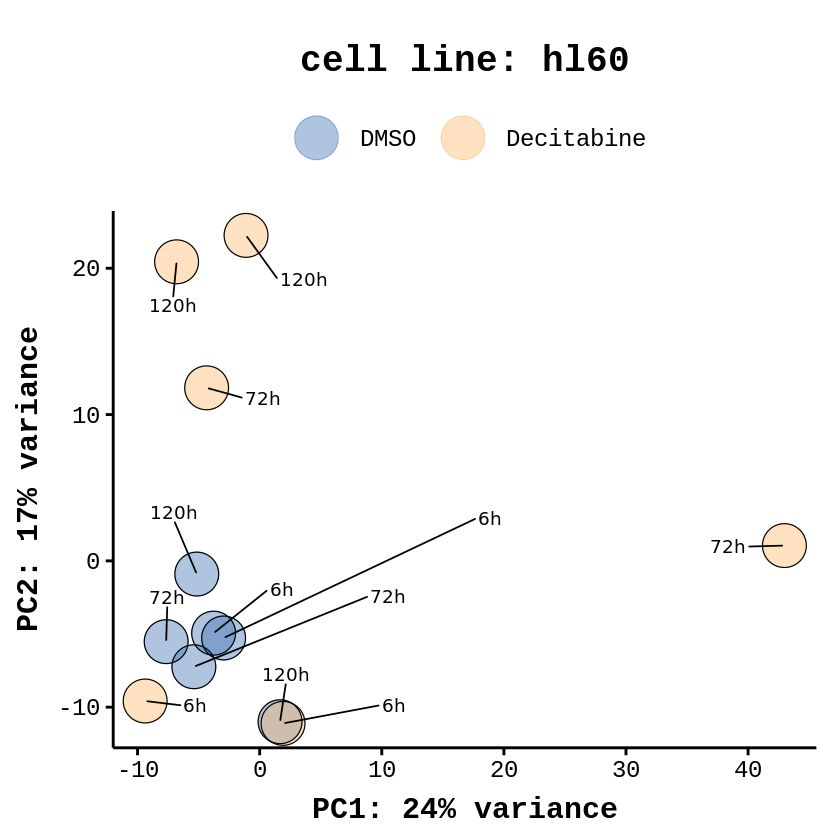

In [28]:
pca_hl60 <- plot_PCA(
    vsd_hl60, 
    colData(vsd_hl60), 
    labels=colData(vsd_hl60)[,'time'],gr=c('cond'), title='cell line: hl60'
)

pca_hl60

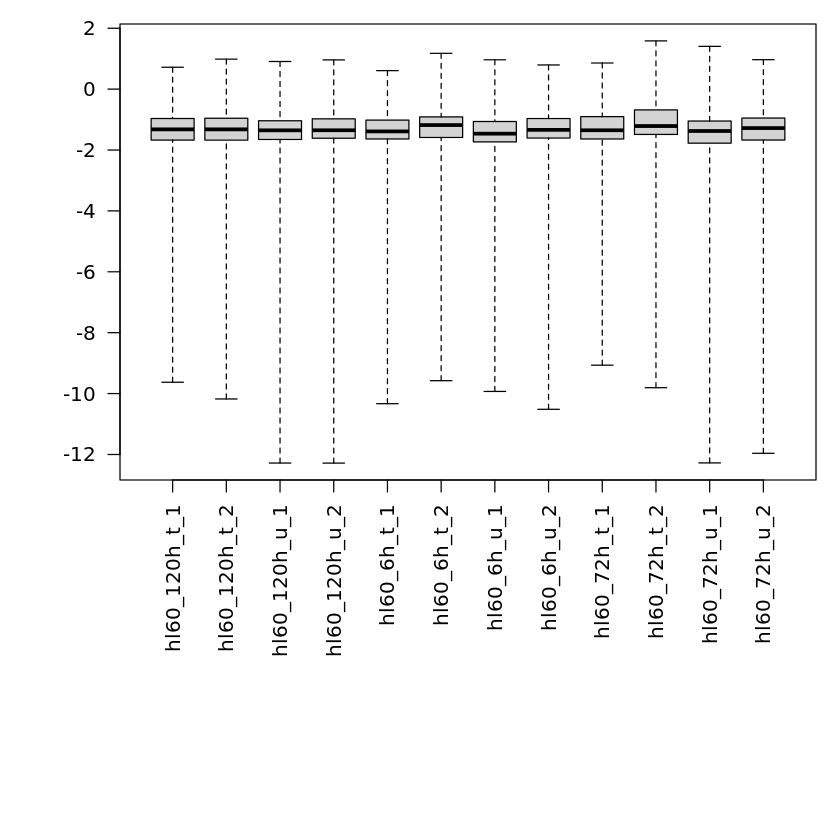

In [22]:
par(mar=c(15,5,1,1))
boxplot(log10(assays(dds.pca)[["cooks"]]), range=0, las=2)

### Differential expression analysis
I'm doing differential expression analysis for treated samples vs. untreated at 6h, 72h and 120h. 

#### First scenario
Time included as factor variable. 

We make two different `dds` object one with with no `cond:time` interaction term and the other one with the interaction term (**ANOVA-like comparison**). 

<!-- Then, I'm replacing results from first object to the secound one for genes with adjust p-values (padj) > 0.05. Hossien Asgharian told me these genes has more accurate estimation from the model with no interaction term.  -->

https://bioconductor.org/packages/release/workflows/vignettes/RNAseq123/inst/doc/designmatrices.html#design-matrices-with-and-without-intercept-term

In [29]:
levels(colData$cond)

[1] "DMSO"       "Decitabine"

In [30]:
model.matrix(~0+cond*time, colData[colData$line=='hl60',])

,condDMSO,condDecitabine,time72h,time120h,condDecitabine:time72h,condDecitabine:time120h
hl60_120h_t_1,0,1,0,1,0,1
hl60_120h_t_2,0,1,0,1,0,1
hl60_120h_u_1,1,0,0,1,0,0
hl60_120h_u_2,1,0,0,1,0,0
hl60_6h_t_1,0,1,0,0,0,0
hl60_6h_t_2,0,1,0,0,0,0
hl60_6h_u_1,1,0,0,0,0,0
hl60_6h_u_2,1,0,0,0,0,0
hl60_72h_t_1,0,1,1,0,1,0
hl60_72h_t_2,0,1,1,0,1,0


In [31]:
dds <- DESeqDataSetFromTximport(txi_hl60, colData[colData$line=='hl60',], ~0 + cond + time + cond:time)

# Annova test
dds <- DESeq(dds, test="LRT", reduced=~1, parallel=TRUE)

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 18 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 18 workers



In [32]:
resultsNames(dds)

[1] "condDMSO"                "condDecitabine"         
[3] "time72h"                 "time120h"               
[5] "condDecitabine.time72h"  "condDecitabine.time120h"

In [33]:
# saveRDS(dds,'dds.rds.gz',compress='gzip')

In [34]:
# dds_ind <- DESeqDataSetFromTximport(txi.gene, colData, ~0+cond + time)

# dds_ind$time <- relevel(dds_ind$time, ref="6h")
# dds_ind$cond <- relevel(dds_ind$cond, ref="DMSO")


# dds_ind <- DESeq(dds_ind, test="LRT", reduced=~1) #, parallel=TRUE)

# resultsNames(dds_ind)

# # no interaction
# res.ind = results(dds_ind,contrast=list("condDMSO","condDecitabine"),listValues=c(1,-1)) %>% ann_Result

In [34]:
# contrast design: treatment at 6h vs dmso at 6h
res.6h  = results(dds, contrast=list("condDecitabine","condDMSO"),listValues=c(1,-1)) #%>% ann_Result

# contrast design: treatment at 72h vs dmso at 72h
res.72h = results(dds, contrast=list(c('condDecitabine', 'condDecitabine.time72h'),c('condDMSO')),listValues=c(1,-1)) #%>% ann_Result

# contrast design: treatment at 120h vs dmso at 120h
res.120h = results(dds, contrast=list(c('condDecitabine', 'condDecitabine.time120h'),c('condDMSO')),listValues=c(1,-1)) #%>% ann_Result

In [35]:
res.6h$pvalue %>% head 

[1]        NA 0.7841738 0.6830851        NA 0.2342729 0.8650101

In [36]:
res.72h$pvalue %>% head 

[1]        NA 0.7841738 0.6830851        NA 0.2342729 0.8650101

In [39]:
# %%R 
# # meta 
# colData.T <- data.frame(
#     time=c(rep(120,4),rep(6,4),rep(72,4)), 
#     cond=rep(c(rep('DMSO',2), rep('Decitabine',2)),3), 
#     time_cond=paste(hours,treats,sep='_'), 
#     sample_id=colnames(txi$abundance),
#     row.names=colnames(txi$abundance))

# dds.T <- DESeqDataSetFromTximport(txi.gene, colData.T, ~cond + time + cond:time)
# dds.T <- DESeq(dds.T, test="LRT", reduced=~1, parallel=TRUE)

In [40]:
# %%R
# resultsNames(dds.T)

In [41]:
# %%R
# res_cnt_time_T_vs_U = results(dds.T, name='cond_Decitabine_vs_DMSO', parallel=T) %>% 
#     data.frame %>% add_column(name = gene2name[rownames(dds.T),]) %>%
#     add_column(ensembl = rownames(dds.T) %>% substr(0, 15))

# p1 = plot_Volcano(res_cnt_time_T_vs_U, 0.1, title='Time as continuous variable: Treated vs DMSO', 
#                   x_min=-2,x_max=2)

In [42]:
# %%R
# res_cnt_time = results(dds.T, name='condDecitabine.time', parallel=T) %>% 
#     data.frame %>% add_column(name = gene2name[rownames(dds.T),]) %>%
#     add_column(ensembl = rownames(dds.T) %>% substr(0, 15))

# p2 = plot_Volcano(res_cnt_time, 0.01, title='Time as continuous variable: Condition and time interaction', 
#                   x_min=-0.1,x_max=0.1)

In [43]:
# %%R
# df = data.frame(
#     'gene_id'=rownames(res_cnt_time_T_vs_U), 'gene_name'= res_cnt_time_T_vs_U$name,
#     'baseMean' = res_cnt_time$baseMean,
#     'log2FC_time' = res_cnt_time$log2FoldChange,'log2FC_time'= res_cnt_time$pval,
#     'log2FC_T_vs_U' = res_cnt_time_T_vs_U$log2FoldChange,'pval_T_vs_U'= res_cnt_time_T_vs_U$pval
# )    
# df = df[order(df$log2FC_time),]

# write_Result(df, 'results_time_continuous.txt', col=TRUE)

In [44]:
# %%R
# plot_Save(p1 / p2, 'Volcano_time_continuous')
# p1 / p2

#### 72 hour only comparison 

In [37]:
# txi_hl60_72h <- tximport(
#     files[grep("hl60_72h", files, fixed=T)], 
#     type = "salmon", tx2gene = tx2gene, txOut=TRUE
# )

# # txi_hl60_72h.gene <- summarizeToGene(txi_hl60_72h, tx2gene, ignoreAfterBar= TRUE)

Define the sample sheet

In [38]:
# dds72h <- DESeqDataSetFromTximport(txi_hl60_72h.gene, colData[colData$time == '72h' & colData$line =='hl60',], ~cond)

# dds72h <- DESeq(dds72h)

In [39]:
# res.72h.only <- results(dds72h,name='cond_Decitabine_vs_DMSO') %>% 
# data.frame %>% ann_Result

In [40]:
# plot_Volcano(res.72h.only,labels=10)

### Save results into a list

In [42]:
RES = list(res.6h,res.72h,res.120h) #res.72h.only,
names(RES) <- c('hl60_6h','hl60_72h','hl60_120h') #'hl60_72h_only',

___
## Decitabine treatment RNA-Seq experiments in 5 other AML cell lines 

Here, I'll run basic DESeq2 analysis 

### Load count data and meta table 

Import salmon quants

In [43]:
txi_other <- tximport(
    files[grep("hl60", files, fixed=T,invert=TRUE)],
    type = "salmon", tx2gene = tx2gene, txOut=TRUE
)

# txi_other.gene <- summarizeToGene(txi_other, tx2gene, ignoreAfterBar= TRUE)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 




### Differential expression analysis


Get results

In [48]:
DDS2 = list()

# for loop to split DESeq object for more stable analysis  
for (l in unique(colData$line) ){
    if (l != 'hl60'){
        print (l)
        k = colData$line == l
        # cell lines with BatchEffect 
        if (l %in% c('thp1','ociaml2') ){
            # dds object for each cell line 
            dds_tmp1 <- DESeqDataSetFromTximport(txi, colData, ~cond + reps)[,c(k)]
            DDS2[[l]]<- DESeq(dds_tmp1) #, parallel=TRUE)
            # rm(dds_tmp1)
        } 
        else {
            dds_tmp2 <- DESeqDataSetFromTximport(txi, colData, ~cond)
            dds_tmp2 <- dds_tmp2[,c(k)] # subset samples from dds object https://www.biostars.org/p/442188/
            DDS2[[l]]<- DESeq(dds_tmp2) #, parallel=TRUE)
            # rm(dds_tmp2)
        }
        # get results 
        res = results(
            DDS2[[l]], 
            contrast=c('cond','Decitabine','DMSO'),
            parallel=TRUE
        )

        RES[[l]] = res 
    }
}

[1] "kg1"


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "molm14"


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "ociaml2"


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "ociaml3"


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "thp1"


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



#### Check direction

In [56]:
RES[['ociaml2']] %>% data.frame %>% arrange(desc(abs(log2FoldChange))) %>% head

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
uc002fnc.2,284.9988,-12.62768,3.843663,-3.285324,1.018652e-03,5.529828e-02
uc001iuf.3,262.0670,12.08659,3.844012,3.144264,1.665052e-03,7.625612e-02
uc001xnr.3,248.4978,-11.95814,3.843674,-3.111122,1.863780e-03,8.223260e-02
uc001hxz.2,262.4489,-11.69887,1.302293,-8.983286,2.627988e-19,6.158253e-16
uc021pks.1,240.5009,-11.07854,1.269557,-8.726300,2.631393e-18,4.624673e-15
uc001nsw.1,310.1475,-11.05498,3.843707,-2.876125,4.025899e-03,1.404569e-01


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



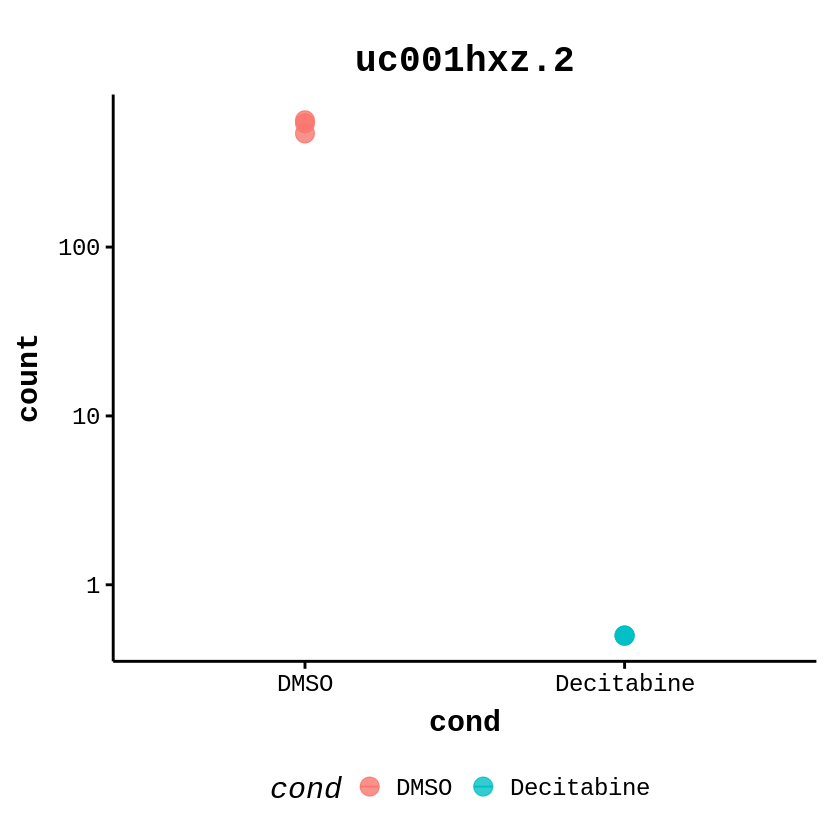

In [89]:
plot_gene_counts(DDS2[['ociaml2']],'uc001hxz.2','uc001hxz.2')

## Merge all fold change data 

In [94]:
result_table = data.frame(
    gene_id=rownames(dds0)
)

In [96]:
for (name in names(RES)){
    print (name)
    
    df = RES[[name]] %>% data.frame %>% select(c('log2FoldChange','pvalue')) 
    
    colnames(df) <- c(paste0(name,"_log2FC"),paste0(name,"_pvalue"))
    cbind(result_table,df%>% remove_rownames) -> result_table
}

[1] "hl60_6h"
[1] "hl60_72h"
[1] "hl60_120h"
[1] "kg1"
[1] "molm14"
[1] "ociaml2"
[1] "ociaml3"
[1] "thp1"


In [97]:
result_table %>% head 

,gene_id,hl60_6h_log2FC,hl60_6h_pvalue,hl60_72h_log2FC,hl60_72h_pvalue,hl60_120h_log2FC,hl60_120h_pvalue,kg1_log2FC,kg1_pvalue,molm14_log2FC,molm14_pvalue,ociaml2_log2FC,ociaml2_pvalue,ociaml3_log2FC,ociaml3_pvalue,thp1_log2FC,thp1_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,uc001aaa.3,NA,NA,NA,NA,NA,NA,NA,NA,-1.9194959,0.63156082,NA,NA,NA,NA,NA,NA
2,uc010nxq.1,2.5043997,0.7841738,-4.6361131,0.7841738,-0.1382060,0.7841738,0.01839997,0.99312927,-2.3581796,0.55465298,0.3844354,0.8997725,-0.16010219,0.96452929,-2.1662936,0.586791909
3,uc010nxr.1,4.5030896,0.6830851,5.4328140,0.6830851,-0.1381478,0.6830851,NA,NA,NA,NA,0.0213155,0.9956948,NA,NA,0.7063051,0.861307914
4,uc009vis.3,NA,NA,NA,NA,NA,NA,7.29156527,0.06224412,NA,NA,-2.0819208,0.5997154,6.44702153,0.09958849,1.3052451,0.742093778
5,uc001aae.4,-0.4279113,0.2342729,-8.1203831,0.2342729,-0.1382915,0.2342729,0.63716627,0.61630931,0.5127029,0.05272666,1.2634239,0.4064782,-0.06893293,0.77453962,8.4398597,0.003098454
6,uc009vit.3,0.1387841,0.8650101,0.3949039,0.8650101,-0.2905831,0.8650101,-1.51590029,NA,-7.7932602,0.01417428,1.2515350,0.7514875,NA,NA,-9.1822087,0.003654520


## Plots

### Correlation matrix

In [98]:
library(Hmisc)
library(corrplot)
library(pheatmap)
library(ggcorrplot)

In [99]:
all_fc <- result_table %>% select(ends_with("log2FC")) 
colnames(all_fc) <- colnames(all_fc) %>% stringr::str_remove(pattern = "_log2FC") %>% unlist


In [100]:
corr <- rcorr(
    as.matrix(
        all_fc %>% select('hl60_6h','hl60_72h','hl60_120h','kg1','molm14','ociaml2','ociaml3','thp1')
    )
)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



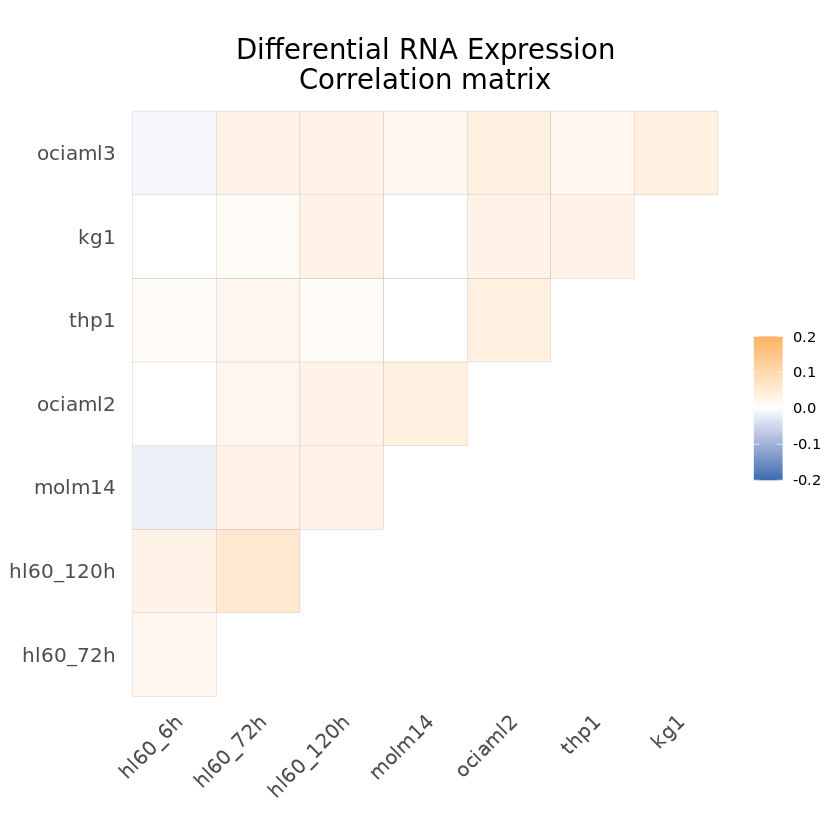

In [102]:
colors=c("#386cb0","white","#fdb462")
ggcorrplot(
    corr$r, 
    method = c("square", "circle"),
    hc.order = TRUE,type = "upper", 
    p.mat = corr$p,
    
) + ggtitle(
    "Differential RNA Expression\nCorrelation matrix"
) + ggplot2::scale_fill_gradient2(
    low = colors[1], high = colors[3], mid = colors[2], 
    midpoint = 0, limit = c(-0.2, 0.2), space = "Lab"
) + theme(
    plot.title = element_text(
        # face = "bold",
        size = rel(1.5), hjust = 0.5),
    panel.background = element_blank(), 
    panel.border = element_blank(), 
    panel.grid.major = element_line(colour = "white"), 
    legend.title = element_blank(),
    # legend.position="bottom"
)

ggsave('exp/plots/logFC_corr.pdf',width = 4, height = 4)

### Volcano plots

In [103]:
plot_Volcano <- function (res, lfc.cutoff, pval.cutoff, title, labels, x_min, x_max) {
    
    colors_values = c("grey80", "tan")

    vol <- res %>% ggplot(aes(x = log2FoldChange, y = -log10(pvalue))) + 
        geom_point(
            data = res %>% filter(
                abs(log2FoldChange) >= lfc.cutoff, 
                pvalue < pval.cutoff), 
            aes(x = log2FoldChange, y = -log10(pvalue)), 
            size = 3, alpha = 5/10, shape = 21, 
            color = colors_values[2],
            fill = colors_values[2]) + 

        geom_point(
            data = res %>% filter(
                (abs(log2FoldChange) < lfc.cutoff) | 
                (pvalue >= pval.cutoff)), 
            aes(x = log2FoldChange, y = -log10(pvalue)), 
            size = 1, alpha = 5/10, shape = 21, color = colors_values[1], 
            fill = colors_values[1]) + 

        # geom_point(
        #     data = res %>% filter(gene_name %in% labels),
        #     aes(x = log2FoldChange, y = -log10(pvalue)), 
        #     shape = 21, size = 3, color = "grey40", fill = "red3") + 
        
        geom_rug(
            data = res %>% filter(
                abs(log2FoldChange) >= lfc.cutoff, 
                pvalue < pval.cutoff), 
            sides = "b", colour='tan') + 

        # geom_label_repel(
        #     data = res %>% filter(gene_name %in% labels), 
        #     aes(label = gene_name), box.padding = 1, max.overlaps = Inf) + 

        xlim(c(x_min, x_max)) + 
        # ylim(c(0, -log10(res %>% select(pvalue) %>% min ))) + 
        geom_hline(yintercept = -log10(pval.cutoff), linetype = "dashed", alpha = 5/10) + 
        geom_text(aes(
            x_min*0.9,-log10(pval.cutoff),
            label = paste("-~log[10]~(",pval.cutoff,')',sep=''), 
            vjust = x_min*0.05
        ),parse = TRUE) +

        theme(
            legend.position = "none"
        ) + 
        ggtitle(title) + theme_Publication()

    return(vol)
}

In [61]:
VOL = list()

In [132]:
names(RES)

[1] "hl60_6h"       "hl60_72h"      "hl60_72h_only" "hl60_120h"    
[5] "kg1"           "molm14"        "ociaml2"       "ociaml3"      
[9] "thp1"

#### hl60 time series

In [108]:
VOL[['hl60_6h']] = plot_Volcano(
    RES[['hl60_6h']] %>% data.frame %>% drop_na(),
    lfc.cutoff  = 2, 
    pval.cutoff = 0.05,
    title  = '6 hours treatment',
    x_min = -10, x_max = 10
)

In [109]:
VOL[['hl60_72h']] = plot_Volcano(
    RES[['hl60_72h']] %>% data.frame %>% drop_na(),
    lfc.cutoff  = 2, 
    pval.cutoff = 0.05,
    title  = '72 hours treatment', 
    x_min = -10, x_max = 10
)

In [112]:
VOL[['hl60_120h']] <- plot_Volcano(
    RES[['hl60_120h']] %>% data.frame %>% drop_na(),
    lfc.cutoff  = 2, 
    pval.cutoff = 0.05,
    title  = '120 hours treatment', 
    x_min = -5, x_max = 5
)

In [113]:
hl60_vol <- VOL[['hl60_6h']] / VOL[['hl60_72h']] / VOL[['hl60_120h']]

# Remove title from first subplot
hl60_vol[[1]] = hl60_vol[[1]] + theme(axis.text.x = element_blank(),
                                        axis.ticks.x = element_blank(),
                                        axis.title.x = element_blank() )

# Remove title from second subplot
hl60_vol[[2]] = hl60_vol[[2]] + theme(axis.text.x = element_blank(),
                                        axis.ticks.x = element_blank(),
                                        axis.title.x = element_blank() )

Warning message:
“Removed 39 rows containing missing values (geom_point).”
Warning message:
“Removed 243 rows containing missing values (geom_point).”


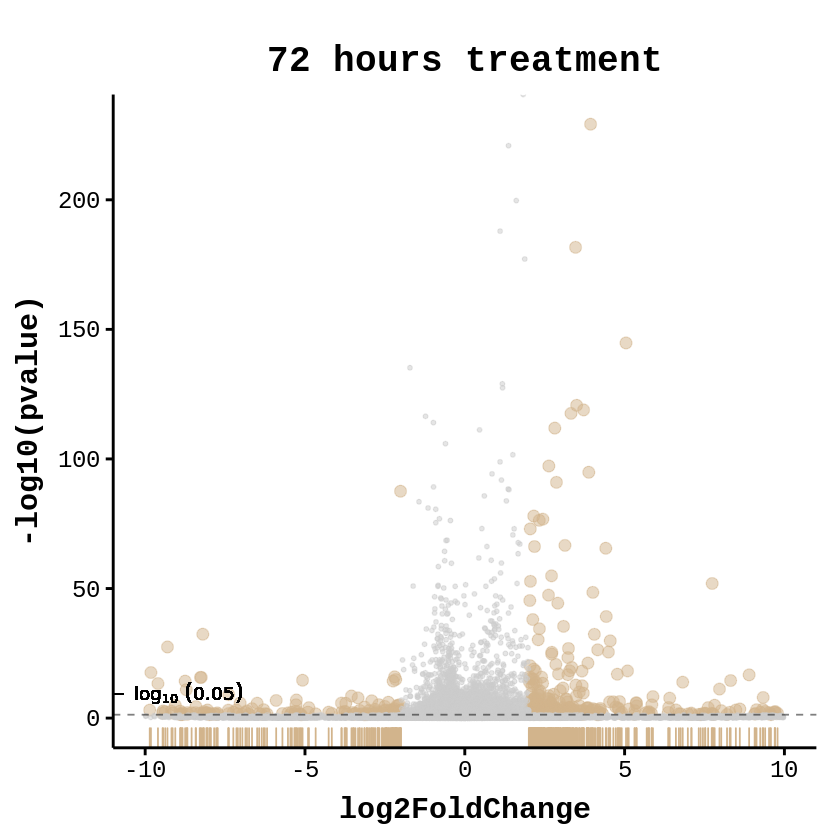

In [114]:
VOL[['hl60_72h']]

In [ ]:
hl60_vol

In [115]:
# ggsave(
#     'exp/plots/volcano_hl60.pdf', 
#     plot = hl60_vol, device = 'pdf', width = 8, height=15
#     #, dpi = 300
# )

# ggsave(
#     'exp/plots/volcano_hl60.png', 
#     plot = hl60_vol, device = 'png', width = 8, height=15, dpi = 300
# )

#### 72h trearment in all cell lines 

In [ ]:
lfc.cutoff = 1
pval.cutoff = 0.05
x_min = -8
x_max = 8


VOL[['hl60_72h_only']] = plot_Volcano(
    RES[['hl60_72h_only']] %>% drop_na(),
    lfc.cutoff, pval.cutoff, 
    title  = 'HL60',
    labels, x_min, x_max
)

VOL[['kg1']] = plot_Volcano(
    RES[['kg1']] %>% drop_na(),
    lfc.cutoff, pval.cutoff,
    title  = 'KG-1',
    labels, x_min, x_max
)

VOL[['molm14']] = plot_Volcano(
    RES[['molm14']] %>% drop_na(),
    lfc.cutoff, pval.cutoff,
    title  = 'MOLM-14', 
    labels, x_min, x_max
)


VOL[['ociaml2']] = plot_Volcano(
    RES[['ociaml2']] %>% drop_na(),
    lfc.cutoff, pval.cutoff, 
    title  = 'OCIAML2',
    labels, x_min, x_max
)

VOL[['ociaml3']] <- plot_Volcano(
    RES[['ociaml3']] %>% drop_na(),
    lfc.cutoff, pval.cutoff,
    title  = 'OCIAML3', 
    labels, x_min, x_max
)

VOL[['thp1']] <- plot_Volcano(
    RES[['thp1']] %>% drop_na(),
    lfc.cutoff, pval.cutoff,
    title  = 'THP-1', 
    labels, x_min, x_max
)

In [ ]:
# pdf('exp/plots/volcano_plots.pdf')
for (name in  names(VOL)){
    # print (VOL[[name]])    
    ggsave(
        paste0('exp/plots/volcano_',name,'.pdf'), 
        plot = VOL[[name]], device = 'pdf', width = 5, height=5, dpi = 300
    )
}
# dev.off()

### Clustering 

In [116]:
# mostVar <- function(data, n, i_want_most_var = TRUE) {
#   data.var <- apply(data, 1, stats::var)
#   data[order(data.var, decreasing = i_want_most_var)[1:n],] 
# }

In [117]:
library(pheatmap)
library(RColorBrewer)

heat_colors <- brewer.pal(n = 6, name = "RdYlBu") %>% rev
greens <- brewer.pal(n = 9, name = "Greens")

### Heatmap to show HL-60 time series clusters

In [118]:
ann_colors = list(
    cond = c('DMSO'="grey90", 'Decitabine'="darkorchid"),
    time = c('120h'= greens[6], '72h'=greens[4], '6h'=greens[2])
)

In [173]:
sub_res = result_table %>%column_to_rownames('gene_id') 
        # filter(
        #     (abs(hl60_72h_log2FC) > 2 & hl60_72h_pvalue  < 0.001)&
        #     (abs(hl60_120h_log2FC)> 2 & hl60_120h_pvalue < 0.001) 
        # ) %>% 

# %>% rownames
sub_res#[tins$GENEID,]

,hl60_6h_log2FC,hl60_6h_pvalue,hl60_72h_log2FC,hl60_72h_pvalue,hl60_120h_log2FC,hl60_120h_pvalue,kg1_log2FC,kg1_pvalue,molm14_log2FC,molm14_pvalue,ociaml2_log2FC,ociaml2_pvalue,ociaml3_log2FC,ociaml3_pvalue,thp1_log2FC,thp1_pvalue
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
uc001aaa.3,NA,NA,NA,NA,NA,NA,NA,NA,-1.919495925,0.63156082,NA,NA,NA,NA,NA,NA
uc010nxq.1,2.50439974,0.78417379,-4.6361131,0.78417379,-0.13820604,0.78417379,0.01839997,0.993129267,-2.358179587,0.55465298,0.38443541,0.8997725,-0.16010219,0.96452929,-2.16629364,5.867919e-01
uc010nxr.1,4.50308956,0.68308506,5.4328140,0.68308506,-0.13814780,0.68308506,NA,NA,NA,NA,0.02131550,0.9956948,NA,NA,0.70630509,8.613079e-01
uc009vis.3,NA,NA,NA,NA,NA,NA,7.29156527,0.062244121,NA,NA,-2.08192077,0.5997154,6.44702153,0.09958849,1.30524509,7.420938e-01
uc001aae.4,-0.42791130,0.23427292,-8.1203831,0.23427292,-0.13829148,0.23427292,0.63716627,0.616309314,0.512702908,0.05272666,1.26342388,0.4064782,-0.06893293,0.77453962,8.43985966,3.098454e-03
uc009vit.3,0.13878407,0.86501015,0.3949039,0.86501015,-0.29058310,0.86501015,-1.51590029,NA,-7.793260217,0.01417428,1.25153504,0.7514875,NA,NA,-9.18220865,3.654520e-03
uc009viu.3,6.64876668,0.24974150,-8.3112049,0.24974150,-0.84939791,0.24974150,-1.68674213,0.517493878,2.133904126,0.51152999,-1.06151407,0.2770192,-6.99218074,0.04713541,-0.92184611,8.103726e-01
uc001aac.4,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
uc001aah.4,NA,NA,NA,NA,NA,NA,NA,NA,-7.062402034,0.07106829,NA,NA,NA,NA,1.34424972,7.340038e-01


png 
  2

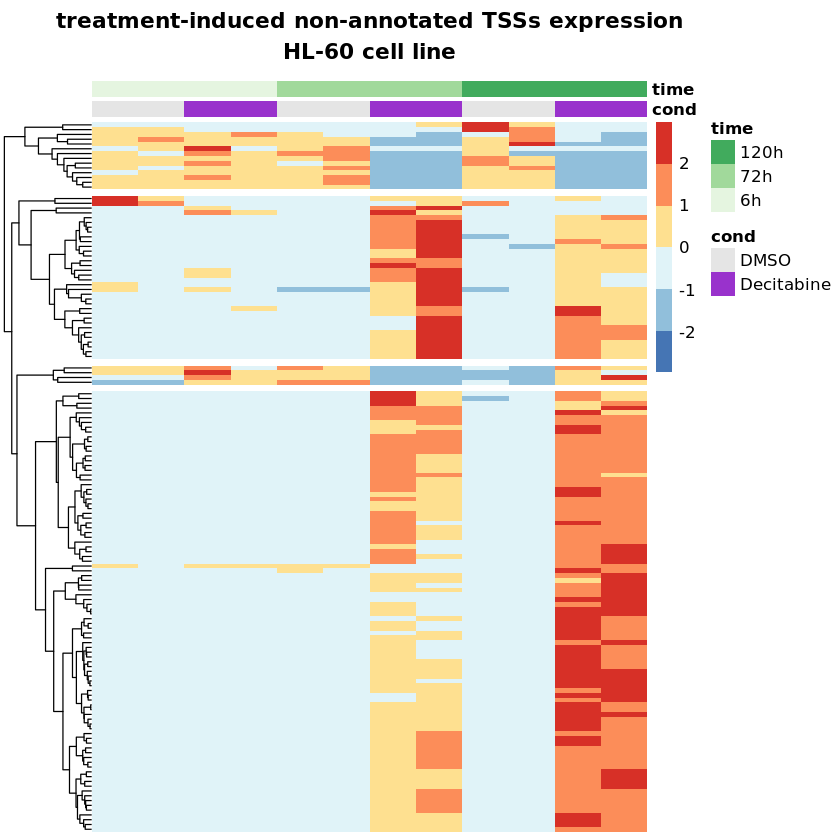

In [151]:
ncu[
    # select genes based on abs(log2FC) and pvalue
    result_table %>%
        filter(
            (abs(hl60_72h_log2FC) > 2 & hl60_72h_pvalue  < 0.001)&
            (abs(hl60_120h_log2FC)> 2 & hl60_120h_pvalue < 0.001) 
        ) %>% column_to_rownames('gene_id') %>% rownames
    ,
    # subset normalized counts
    colData[colData$line=='hl60',c('cond','time')] %>% arrange(time,cond) %>% rownames
] %>% 
    # generate heatmap
    pheatmap(
        color = heat_colors, 
        show_colnames = F,
        show_rownames = F,
        cutree_rows = 4,
        main = 'treatment-induced non-annotated TSSs expression\nHL-60 cell line',
        annotation = colData[colData$line=='hl60',c('cond','time')],
        cluster_cols = F, 
        scale = 'row',
        angle_col= 45,
        annotation_colors = ann_colors
) -> hm_hl60

# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('tinat/heatmap_clustering_hl60.pdf', width=4, height=7)
grid::grid.newpage()
grid::grid.draw(hm_hl60$gtable)
dev.off()

## Save results 

In [146]:
# write all results into one file 
write.table(
    result_table %>% column_to_rownames('gene_id'), 
    'tinat/delta_exp_table.txt', quote = F, col.names=TRUE, row.names=TRUE,sep ='\t'
)

# Session Info

In [147]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data_gilbert/home/aarab/anaconda3/envs/deseq2/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] RColorBrewer_1.1-2          ggcorrplot_0.1.3           
 [3] pheatmap_1.0.12             corrplot_0.92              
 [5] Hmisc_4.6-0                 Formula_1.2-4              
 [7] survival_3.2-13             lattice_0.20-45            
 [9] ggthemes_4.2.4   

In [148]:
date()

[1] "Thu Aug 25 13:26:01 2022"